# Seminarska naloga iz Podatkovnega Rudarjenja 2020/2021

### Odločili smo se za nalogo: ukradena vozila.

### <font color='orange'>In progress [ &#9874; ] </font>&nbsp; <font color='red'>Declined [ ✗ ]</font> &nbsp;<font color='green'>Finished [ ✓ ]</font>

* <font color='green'>Priprava osnovnega parserja [ ✓ ]</font>   <br/>
* <font color='green'>Priprava tabele z kraticami in mesti registracijskih [ ✓ ]</font>   <br/>
* <font color='green'>Pridobi možne podatke s spletne strani avtolog.si [ ✓ ]</font>   <br/>
* <font color='green'>v katerem mestu je največ kraj( glede na tablico MB,LJ,..) [ ✓ ] </font>  <br/>
* <font color='green'>katera znamka je najbolj kradena [ ✓ ] </font><font color='orange'>(lahko tudi glede na mesto) [ &#9874; ] </font> <br/>
* <font color='green'>kateri tip je najbolj kraden [ ✓ ] </font><font color='orange'>(lahko tudi glede na mesto) [ &#9874; ] </font> <br/>
* <font color='green'>ali je večina ukradenih starejših/novejših od X leta [ ✓ ]</font> <i>Novejši od 4 let </i>  <br/>
* <font color='red'>ali so ukredena vozila dražja/cenejša od X vrednosti [ ✗ ]</font>  <br/>
* <font color='green'>koliko vozil je bilo ukradenih za vsako leto [ ✓ ]</font>  <br/>
* <font color='orange'>katera barva je najbolj kradena [ &#9874; ]</font>  <br/>
* <font color='orange'>??Ali so cena avtomobila in kraja avtomobila povezana [ &#9874; ]</font>  <br/>
* <font color='orange'>Verjetnost, da ti ukradejo avto če si iz mesta X (st_Ukradenih_avtov_mesto / prebivalstvo_mesto) [ &#9874; ]</font>  <br/>
* <font color='green'>Kraja po starosti vozila [ ✓ ]</font>  <br/>



In [1]:
import pandas as pd
import requests
from bs4 import BeautifulSoup
import urllib.request
import json 
import re
import csv
from collections import defaultdict
import matplotlib.pyplot as plt
from itertools import islice

import functools #Za unikatne igralce
import operator #Za unikatne igralce
from collections import Counter #Za stetje dolocenih

import datetime

In [2]:
#import sys
#!{sys.executable} -m pip install beautifulsoup4

In [3]:
vozila = pd.read_csv("ukrvozila.csv", sep=";")
kMesta = pd.read_csv("kraticeMesta.csv", sep=";")

In [4]:
KM = {}
for index, row in kMesta.iterrows():
    KM[row[0]] = row[1]
#KM["Drugo"] = "Drugo"

In [5]:
vozila['znamka'].isnull().values.any() #true
vozila['tip'].isnull().values.any() #true
vozila['registrska'].isnull().values.any() #true
vozila['sasija'].isnull().values.any() #false
vozila['barva'].isnull().values.any() #true
vozila['datumodvzema'].isnull().values.any() #false

False

In [6]:
vozila['znamka'] = vozila['znamka'].fillna("BREZ")
vozila['tip'] = vozila['tip'].fillna("BREZ")
vozila['registrska'] = vozila['registrska'].fillna("BREZ")
vozila['barva'] = vozila['barva'].fillna("BREZ")

In [7]:
#Znebimo se vseh nepopolnih registerskih za lažjo predstavitev podatkov.
vozila.loc[(vozila["registrska"] == ''), 'registrska'] = "BREZ"
vozila.loc[(vozila["registrska"] == 'N'), 'registrska'] = "BREZ"
vozila.loc[(vozila["registrska"] == '0'), 'registrska'] = "BREZ"
vozila.loc[(vozila["registrska"] == 'X'), 'registrska'] = "BREZ"

## Parser

In [8]:
def getWebsiteData(sasija):
    
    url="http://avtolog.si/search/"+sasija+"/"
    html_content = requests.get(url).text
    parsed_html = BeautifulSoup(html_content,'html.parser')
    
    ## Get table data
    allTables = parsed_html.find_all("div", attrs={"class": "pane"})
    
    #Take the usefull data: Podatki o vozilu; Podatki o lastniku.
    d1 = allTables[0]
    d3 = allTables[2]

    t1 = d1.findAll("table")[0]
    t_headers = []
    for th in t1.find_all("th"):
        # remove any newlines and extra spaces from left and right
        t_headers.append(th.text.replace('\n', ' ').strip())
    #print(t_headers)
    table_data = []
    for td in t1.find_all("td"):
        a = re.sub("\n +"," ", td.text.strip())
        tdt = re.sub(" +"," ", a)
        table_data.append(tdt)
    sz = [x for x in zip(t_headers, table_data)]    
    if(d3.findAll("table") != []):
        t3 = d3.findAll("table")[0]
        tds = t3.find_all("td")[-3]
        a = re.sub("\n +"," ", tds.text.strip())
        sz.append(('Status/starost',re.sub(" +"," ", a)))
    s = ("sasija", sasija)
    sz.insert(0,s)
    return sz


In [9]:
#getWebsiteData("SWNH30000A0002248")

In [10]:
#V0_2000 = vozila["sasija"][0:2000] #done
#V2000_4000 = vozila["sasija"][2000:4000] #done
#V4000_6000 = vozila["sasija"][4000:6000] #done
#V6000_8000 = vozila["sasija"][6000:8000] #done
#V8000_10000 = vozila["sasija"][8000:10000] #done
#V10000_12000 = vozila["sasija"][10000:12000] #done
#V12000_14000 = vozila["sasija"][12000:14000] #done
#V14000_16000 = vozila["sasija"][14000:16000] #done
#V16000_konc = vozila["sasija"][16000:] #done

In [11]:
#print(len(V0_2000) + len(V2000_4000) + len(V4000_6000) + len(V6000_8000) + len(V8000_10000) + len(V10000_12000) + len(V12000_14000) + len(V14000_16000) + len(V16000_konc))

In [12]:
#Done: 6000 - errors
#V0_2000, 2000-4000, 4000-6000, 6000-8000, 8000-10000, 10000-12000
def getDataFromRange(array):
    c = 0;
    dataArray = []
    errorArray = []
    for x in array:
        try:
            podatki = getWebsiteData(x)
            dataArray.append(podatki)
        except:
            errorArray.append(c)
        c+=1
    return (dataArray, errorArray)


In [13]:
#Zaženi na vsake nekaj časa, da ne preobremenimo strežnika.
#dataArray, errorArray = getDataFromRange(V16000_konc)


In [14]:
#Preveri ali so podakti pravilno zapisani
#dataArray

In [15]:
#counter = []
#for x in dataArray:
#    counter.append(len(x))

In [16]:
#Preveri ali imajo vsi najmanj 12 in največ 13 vnosov.
#set(counter)

In [17]:
#errorArray

In [18]:
#vozila.iloc[16000+18]

In [19]:
def addTotxtError(array, zacetna):
    file = open('napake.txt', 'a')
    for x in array:
        er = vozila["sasija"].iloc[x+zacetna]
        file.write(er + "\n")
    file.close()


In [20]:
def firstCsv():
    with open('normal.csv', mode='a', newline='') as voz_file:
        voz_writer = csv.writer(voz_file, delimiter=';', quotechar='"', quoting=csv.QUOTE_MINIMAL)
        headers = []
        for x in dataArray[0]:
            headers.append(x[0])
        voz_writer.writerow(headers)
        voz_file.close()

def addTocsvNormal(array):
     with open('normal.csv', mode='a', newline='') as voz_file:
        voz_writer = csv.writer(voz_file, delimiter=';', quotechar='"', quoting=csv.QUOTE_MINIMAL)
        for x in array:
            podatki = [y[1] for y in x]
            if len(podatki) == 12:
                podatki.append("BREZ")
            voz_writer.writerow(podatki)    
        voz_file.close()

In [21]:
#Ko dobiš nove podatke zapiši vse errorje v datoteko.
#addTotxtError(errorArray, 16000)

In [22]:
#Zaženi samo prvič, da se ustvarijo headerji
#firstCsv()

In [23]:
#Vsakič ko dobiš nove podatke, zaženi.
#addTocsvNormal(dataArray)

# Obdelava podatkov | statistika podatkov

In [24]:
##Pridobi združeno tabelo po šasiji
vozilaAL = pd.read_csv("normal.csv", sep=";")
#merge = vozila.merge(avtolog)

In [25]:
#vozilaAL

In [26]:
#Za boljše podatke smo odstranili vse tiste podatke, ki so bili pomanjklivi(Niso imeli šasije ali pa je bila napačna)
#Napake so napisane v napake.txt, zato jih je potrebno odstraniti. To pa zato, da bodo vse šasije unikatne.
f = open("napake.txt", "r")
a = set()

for x in f: 
  a.add(x.strip())

In [27]:
vozila = vozila[~vozila['sasija'].isin(a)]
#Obe tabeli imata sedaj 16786 zapisov. Kar pa bo zelo uporabno pri zruževanju podatkov.

In [28]:
vozila["sasija"].nunique()

16657

In [29]:
vozilaAL["sasija"].nunique()

16657

In [30]:
#Združeno skupaj in preverjeno, da se vsi zapisi ujemajo
merged = pd.concat([vozila.reset_index(drop=True),vozilaAL.reset_index(drop=True)], axis=1)

In [31]:
#Izbrisan podvojen podatek šasije
merged = merged.iloc[:, [j for j, c in enumerate(merged.columns) if j != 6]]

In [32]:
#Znebimo se vseh praznih vrednosti
merged = merged.fillna("BREZ")

In [33]:
#Obstajajo tudi podvojeni zapisi(bodisi večkrat ukradeni, bodisi večkrat prijavljeni)
#merged[merged.duplicated(subset=['sasija'])]

In [34]:
#Podvojeni zapisi
del merged["Znamka vozila"]
del merged["Barva"]

### Statistika po posameznih mestih

In [35]:
#Množica vseh veljavnih registerskih tablic
mesta = set(kMesta["Kratica"])

In [36]:
#Slovar, ki drži število vseh ponovitev posameze oznake registerske
poMestih = defaultdict(int)
for index, row in merged.iterrows():
    mesto = row[2][0:2]
    if (mesto[0] == "P" and mesto[1].isdigit()):
        poMestih["P"] += 1
    elif (mesto[0] == "M" and mesto[1].isdigit()):
        poMestih["M"] += 1
    else:
        if mesto in mesta:
            poMestih[mesto] += 1
        else:
            poMestih["Drugo"] += 1

In [37]:
#Glede na vrednost slovar uredi.
poMestihUrejen = {key: value for key, value in sorted(poMestih.items(), key=lambda item: item[1])}

In [38]:
mesta = poMestihUrejen.keys()
stKraj = poMestihUrejen.values()



In [39]:
kMesta["Mesto"][kMesta["Kratica"] == "CE"][0]

'Celje'

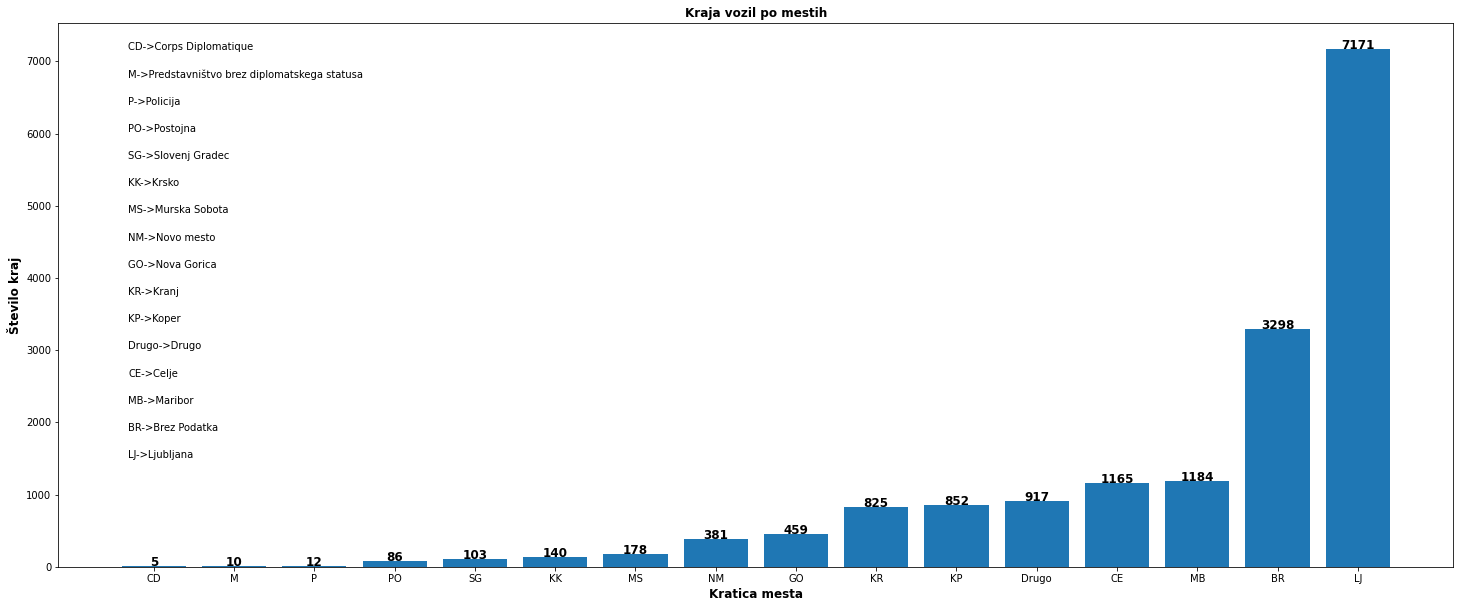

In [40]:
#Izris urejenega grafa.
plt.figure(figsize=(25,10))
plt.bar(mesta, stKraj)
plt.title("Kraja vozil po mestih", fontweight="bold", fontsize="large")
plt.xlabel("Kratica mesta", fontweight="bold", fontsize="large")
plt.ylabel("Število kraj", fontweight="bold", fontsize="large")
for index, value in enumerate(poMestihUrejen.values()):
    plt.text(index, value, str(value), color="black", fontweight="bold", fontsize="large", ha="center")
x = 0.05
y = 0.95
for mesto in mesta:
    plt.annotate(mesto + "->" + KM[mesto], xy=(x, y), xycoords='axes fraction')
    y -= 0.05
plt.show()


### Katera znamka je največkrat kradena?

In [41]:
poZnamkah = defaultdict(int)
for x in merged["znamka"]:
    poZnamkah[x] += 1

In [42]:
poZnamkahUrejen = {key: value for key, value in reversed(sorted(poZnamkah.items(), key=lambda item: item[1]))}

In [43]:
i = 0
znamke = []
stZnamk = []
for key, value in poZnamkahUrejen.items():
    if i < 10:
        znamke.append(key)
        stZnamk.append(value)
    else:
        break
    i+=1

#### 10 največkrat ukradenih znamk

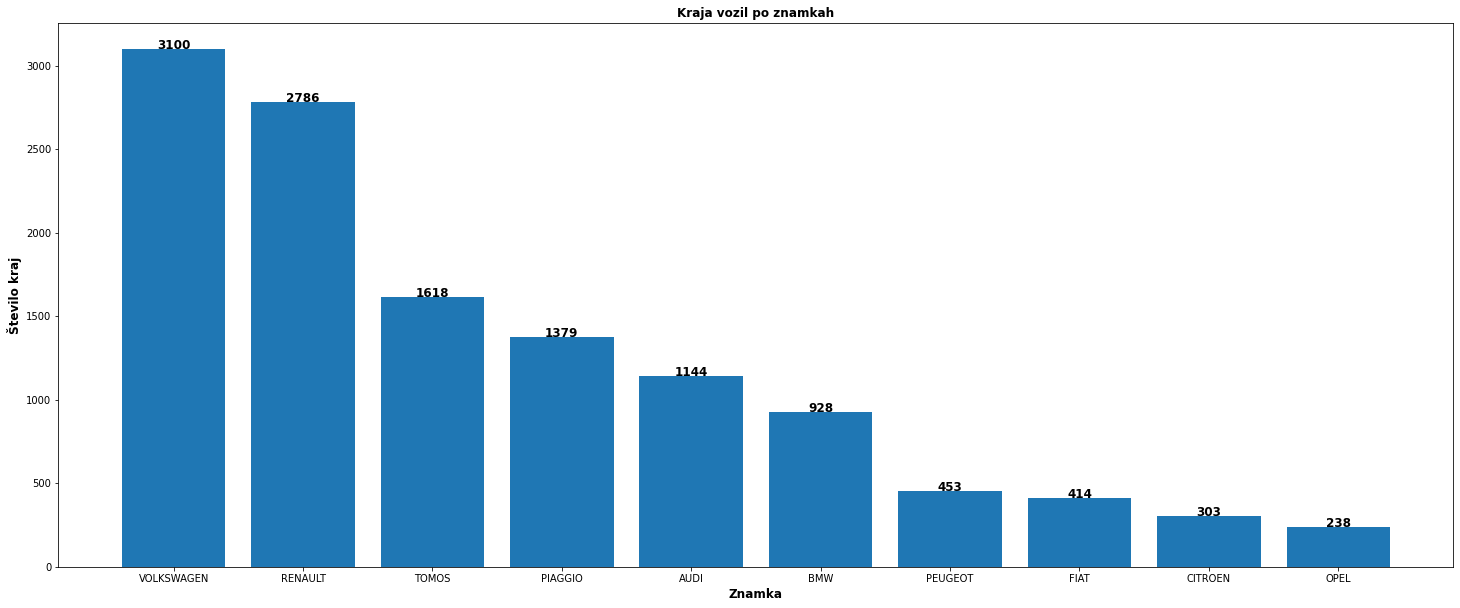

In [44]:
plt.figure(figsize=(25,10))
plt.bar(znamke, stZnamk)
plt.title("Kraja vozil po znamkah", fontweight="bold", fontsize="large")
plt.xlabel("Znamka", fontweight="bold", fontsize="large")
plt.ylabel("Število kraj", fontweight="bold", fontsize="large")
for index, value in enumerate(stZnamk):
    plt.text(index, value, str(value), color="black", fontweight="bold", fontsize="large", ha="center")
plt.show()

### Kateri tip je največkrat kraden?

In [45]:
poTipih = Counter(merged["tip"])
poTipihUrejen = {key: value for key, value in reversed(sorted(poTipih.items(), key=lambda item: item[1]))}
#len(poTipihUrejen)

#Zbrisano, saj nas zanimajo samo obstajajoči zapisi.
del poTipihUrejen["BREZ"] 
del poTipihUrejen["VSI TIPI"] 

In [46]:
i = 0
tipi = []
stTipov = []
for key, value in poTipihUrejen.items():
    if i < 10:
        tipi.append(key)
        stTipov.append(value)
    else:
        break
    i+=1

#### 10 največkrat ukradenih tipov

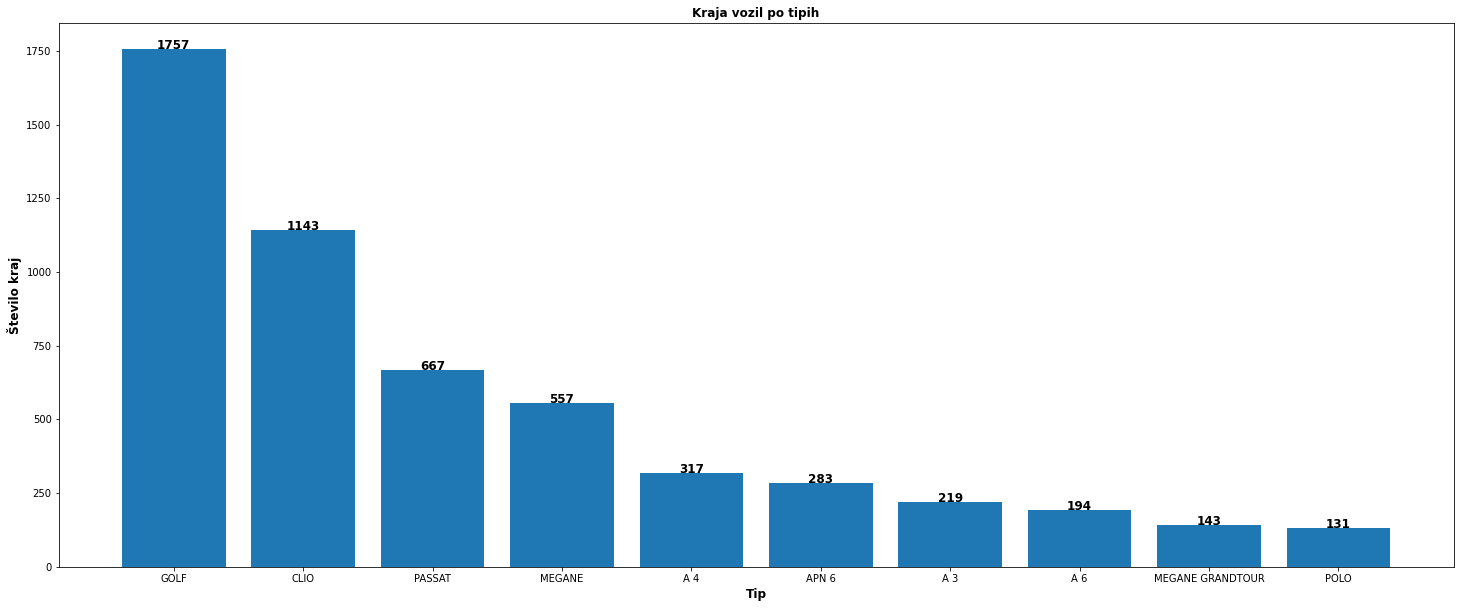

In [47]:
plt.figure(figsize=(25,10))
plt.bar(tipi, stTipov)
plt.title("Kraja vozil po tipih", fontweight="bold", fontsize="large")
plt.xlabel("Tip", fontweight="bold", fontsize="large")
plt.ylabel("Število kraj", fontweight="bold", fontsize="large")
for index, value in enumerate(stTipov):
    plt.text(index, value, str(value), color="black", fontweight="bold", fontsize="large", ha="center")
plt.show()

### Kraja vozil po letih

In [48]:
noerror = 0
poLetih = defaultdict(int)
for x in merged["datumodvzema"]:
    try:
        l = x.split(".")
        leto = l[2]
        poLetih[leto] += 1
    except:
        noerror += 1

In [49]:
poLetihUrejen = {key: value for key, value in reversed(sorted(poLetih.items(), key=lambda item: item[1]))}

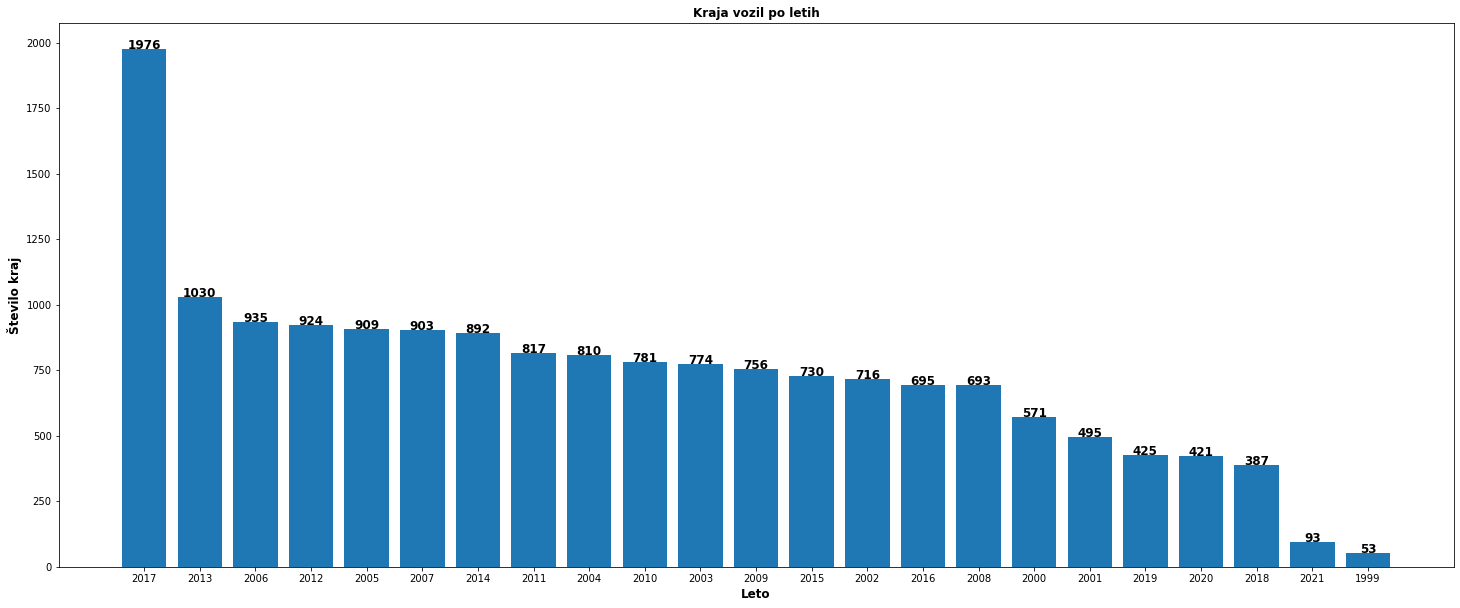

In [50]:
plt.figure(figsize=(25,10))

plt.bar(*zip(*poLetihUrejen.items()))
for index, value in enumerate(poLetihUrejen.values()):
    plt.text(index, value, str(value), color="black", fontweight="bold", fontsize="large", ha="center")
    
plt.title("Kraja vozil po letih", fontweight="bold", fontsize="large")
plt.xlabel("Leto", fontweight="bold", fontsize="large")
plt.ylabel("Število kraj", fontweight="bold", fontsize="large")

plt.show()

In [51]:
print(round(sum(poLetihUrejen.values()) / len(poLetihUrejen),2))

729.83


**Iz gornjega grafa je razvidno, da je bilo največ kraj zabeleženo leta 2017. Najmanj pa leta 1999. Povprečje pa je 730 zabeleženih kraj na leto.**

In [52]:
#~3000 Zapisov nima podatka o prvi registraciji.
novaStara = {"Novo" : 0, "Staro" : 0}
er = 0
for index, row in merged[["Prva registracija","datumodvzema"]][merged["Prva registracija"] != "None"].iterrows():
    try:
        l = row[0].split("-")
        leto = int(l[0])
        l2 = row[1].split(".")
        leto2 = int(l2[2])
        if leto2 - leto <= 4:
            novaStara["Novo"] += 1
        else:
            novaStara["Staro"] += 1
    except:
        er +=1


In [53]:
starost = [novaStara["Novo"], novaStara["Staro"]]
n = '#6404CB'
s = '#04B6CB'



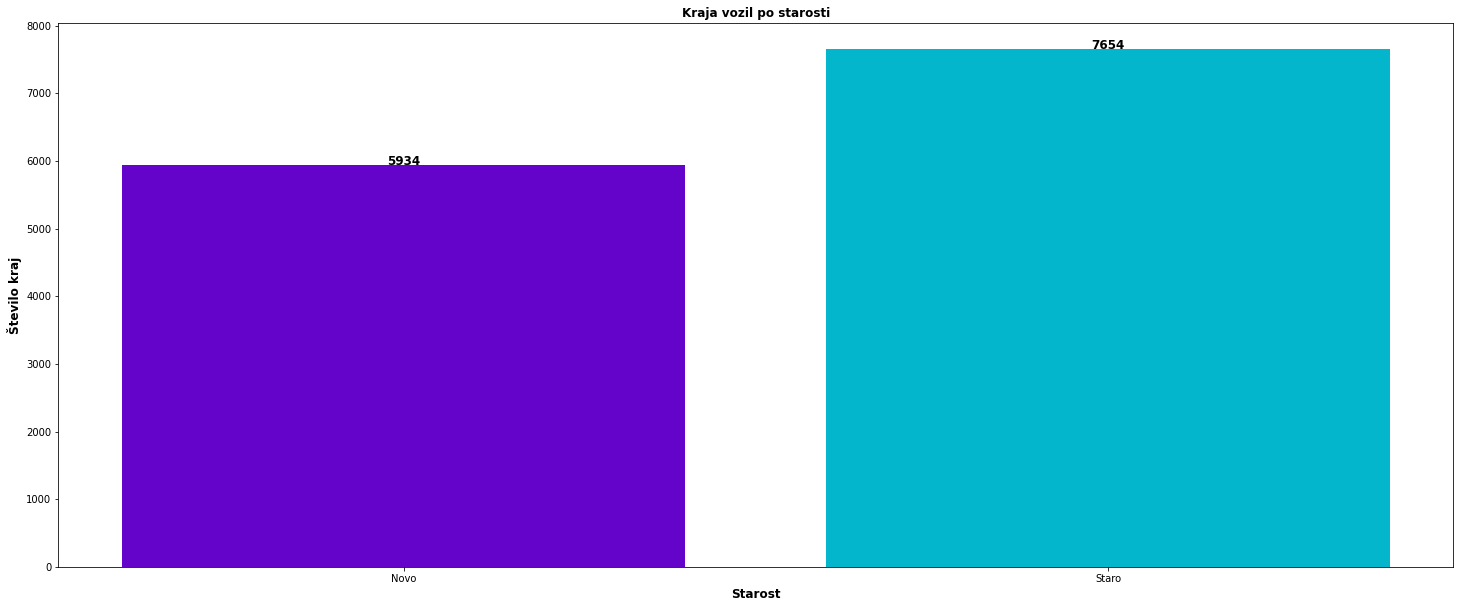

In [54]:
plt.figure(figsize=(25,10))

plt.bar(range(2), height=(starost), tick_label=("Novo", "Staro"), color=(n,s))
for index, value in enumerate(starost):
    plt.text(index, value, str(value), color="black", fontweight="bold", fontsize="large", ha="center")
    
plt.title("Kraja vozil po starosti", fontweight="bold", fontsize="large")
plt.xlabel("Starost", fontweight="bold", fontsize="large")
plt.ylabel("Število kraj", fontweight="bold", fontsize="large")
    
plt.show()

In [55]:
print(round(7654 / (7654 + 5934) * 100,2))
print(round(5934 / (7654 + 5934) * 100,2))

56.33
43.67


**Iz zgornjega grafa je razvidno, da je bilo veliko več kraj starejših kot pa novejših vozil in sicer 13184:457. Okoli 97% vozil je bilo starejših od 4 let. 3% pa so novejši avtomobili, kar pomeni da so stari <= 4 leta.**

In [56]:
#Get population by city

def getCityPopulation(city):
    c = city.split(" ")
    s = ""
    if len(c) == 2:
        s = c[0]+"+"+c[1]
    else:
        s = str(c[0])
    with urllib.request.urlopen("https://public.opendatasoft.com/api/records/1.0/search/?dataset=worldcitiespop&q="+s) as url:
        data = json.loads(url.read().decode())
        for x in data["records"]:
            try:
                nov = x["fields"]["population"]
                break
            except:
                nov = 0
        return nov
        

In [57]:
#d = getCityPopulation("Krsko")

In [58]:
#Pridobivanje podatkov o populaciji posameznih mest
#https://public.opendatasoft.com/explore/?sort=modified
def getallCityPop():
    izkljuci = {"M","CD","P","BR","Drugo"}
    pop = []
    for index, row in kMesta.iterrows():
        kratica, mesto, pop = row
        if kratica not in izkljuci:
            print(mesto)
            pop.append(getCityPopulation(mesto))
        else:
            pop.append(0)
    return pop

In [59]:
#pop = getAllCityPop()
#kMesta.insert(2, "Populacija", pop, True)

In [60]:
#kMesta.to_csv("kraticeMesta.csv", sep = ';', index=False)